
**ONLINE SHOPPERS INTENTION DATASET( CLUSTERING ANALYSIS)**

**Task 2**: Unsupervised learning project involving EDA, preprocessing,
Clustering with K-Means and Gaussian Mixture Models (GMM), Visualization, Evaluation 
and Business interpretation.

**Dataset**: Online Shoppers Purchasing Intention (UCI Machine Learning Repository)

**Online Shoppers Intention (K-Means & Gaussian Mixture Model Clustering)**

This notebook implements a full unsupervised machine learning workflow using the 
Online Shoppers Purchasing Intention Dataset from the UCI Machine Learning Repository.
The goal of the project is to explore user behaviour, perform clustering, and interpret
meaningful shopper segments that can support business decision-making.


**What this Code Does**

1. Loads and prepares the dataset

   a.Reads the Online Shoppers dataset directly from a ZIP file.

   b.Prints dataset structure, data types, and initial samples.
       
   c.Calculates and saves basic EDA outputs such as missing values and summary statistics.

In [1]:

# Loading the necessary Libraries

import os, io, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:

# Set a single output folder for everything


# This directory will store all my EDA output, plots, and generated results.
PREVIEW_DIR = "Online_Shoppers_dataset_Results"
os.makedirs(PREVIEW_DIR, exist_ok=True)

# Creating additional subfolders for better organisation of my work
PLOTS_DIR = os.path.join(PREVIEW_DIR, "Plots")      # Folder for all visualisations
TABLES_DIR = os.path.join(PREVIEW_DIR, "Tables")    # Folder for cleaned tables, summaries, etc.

# Generating the folders if they don't already exist
for d in [PREVIEW_DIR, PLOTS_DIR, TABLES_DIR]:
    os.makedirs(d, exist_ok=True)

# Confirming the directory setup
print(f"✅ All results will be saved under: {os.path.abspath(PREVIEW_DIR)}")


✅ All results will be saved under: C:\Users\EDI\Documents\1 MLDM OGUNMAKINWA_@00796689\ONLINE SHOPPERS(TASK 2)\Online_Shoppers_dataset_Results


In [3]:

# Loading the Dataset (Online Shoppers Purchasing Intents)

# Creating a folder to store any figures I generate during testing
os.makedirs("figs", exist_ok=True)

# Expanding column display so I can quickly inspect the dataset without truncation
pd.set_option("display.max_columns", 100)

# Path to the zipped dataset I downloaded
ZIP_PATH = r"C:\Users\EDI\Downloads\online+shoppers+purchasing+intention+dataset.zip"


def load_csv_from_zip(zip_path, prefer_contains="online", fallback_ext=".csv", encoding="utf-8"):
    """
    Custom helper function I wrote to automatically detect and load the correct CSV 
    from a compressed zip file.
    
    - prefer_contains: keyword to guide the selection of the right CSV inside the archive.
    - fallback_ext: extension used to identify CSV files in case the naming isn't clear.
    - encoding: ensures smooth reading of the file even when there are mixed encodings.
    """
    with zipfile.ZipFile(zip_path, "r") as zf:
        
        # Listing all files inside the zip and filtering out the CSV files
        names = zf.namelist()
        csvs = [n for n in names if n.lower().endswith(".csv")]
        if not csvs:
            raise FileNotFoundError("No CSV files found inside the zip.")

        # Attempting to pick the most relevant CSV using the provided keyword
        choice = None
        for n in csvs:
            if prefer_contains.lower() in n.lower():
                choice = n
                break

        # If no filename matches the hint, I pick the largest CSV file inside the archive
        if choice is None:
            csvs_sorted = sorted(csvs, key=lambda n: zf.getinfo(n).file_size, reverse=True)
            choice = csvs_sorted[0]

        print(f"Loading CSV from zip: {choice}")

        # Reading the chosen CSV file safely with a text wrapper
        with zf.open(choice, "r") as f:
            txt = io.TextIOWrapper(f, encoding=encoding, errors="replace")
            df = pd.read_csv(txt)

    return df

In [4]:

# Checking that the dataset ZIP file exists before attempting to load it
if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(
        f"Could not find '{ZIP_PATH}'. Please place the downloaded UCI zip file in this directory or update the variable name."
    )

# Loading the dataset using my helper function
df = load_csv_from_zip(ZIP_PATH)

# Basic overview of the dataset immediately after loading
print("\n=== Basic Info ===")
print("Shape (rows, cols):", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes.value_counts())

# Ensuring that boolean-like fields are properly converted to Boolean dtype
for col in ["Revenue", "Weekend"]:
    if col in df.columns and df[col].dtype == object:
        df[col] = df[col].astype(str).strip().str.lower().map({"true": True, "false": False})
        
        # If some values don't map cleanly, treat remaining values as 1/0
        if df[col].isna().any():
            df[col] = df[col].fillna(0).astype(bool)

print("\nHead:\n", df.head())


# Saving a preview of the dataset (first few rows)

PREVIEW_DIR = "Online_Shoppers_dataset_Results"
os.makedirs(PREVIEW_DIR, exist_ok=True)

# Saving the first 10 rows of the dataset as a preview
preview_csv_path = os.path.join(PREVIEW_DIR, "Online_Shoppers_dataset_preview.csv")
df.head(10).to_csv(preview_csv_path, index=False)

print(f"\n💾 Dataset preview (first 10 rows) saved to: {preview_csv_path}")


Loading CSV from zip: online_shoppers_intention.csv

=== Basic Info ===
Shape (rows, cols): (12330, 18)

Columns:
 ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']

Data types:
 int64      7
float64    7
object     2
bool       2
Name: count, dtype: int64

Head:
    Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1               

**2. Performs Exploratory Data Analysis (EDA)**

   a. Generates histograms for key behavioural features (e.g., BounceRates, ExitRates, PageValues).

   b. Computes the overall purchase rate (~15%).
                                          
   c. Saves all visualisations and tables in a structured results folder.

In [5]:

#  EDA (Exploring the dataset and checking for missing values, numeric summary, and categorical summary)


# Checking for missing values across the dataset
missing_values = df.isna().sum().reset_index()
missing_values.columns = ["Column", "Missing_Count"]
missing_values.to_csv(os.path.join(TABLES_DIR, "missing_values.csv"), index=False)
display(missing_values.head(10))

# Summary statistics for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 0:
    describe_numeric = df[num_cols].describe().T
    describe_numeric.to_csv(os.path.join(TABLES_DIR, "describe_numeric.csv"))
    display(describe_numeric)

# Summary statistics for categorical columns
cat_cols = [c for c in df.columns if c not in num_cols]
if len(cat_cols) > 0:
    describe_categorical = df[cat_cols].describe().T
    describe_categorical.to_csv(os.path.join(TABLES_DIR, "describe_categorical.csv"))
    display(describe_categorical)

# Quick dataset overview saved for reference
pd.DataFrame({
    "Rows": [df.shape[0]],
    "Columns": [df.shape[1]],
    "Numeric_Cols": [len(num_cols)],
    "Categorical_Cols": [len(cat_cols)]
}).to_csv(os.path.join(PREVIEW_DIR, "eda_overview.csv"), index=False)

print(f"💾 EDA summaries saved in {os.path.abspath(TABLES_DIR)}")


,Column,Missing_Count
0,Administrative,0
1,Administrative_Duration,0
2,Informational,0
3,Informational_Duration,0
4,ProductRelated,0
5,ProductRelated_Duration,0
6,BounceRates,0
7,ExitRates,0
8,PageValues,0
9,SpecialDay,0


,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


,count,unique,top,freq
Month,12330,10,May,3364
VisitorType,12330,3,Returning_Visitor,10551
Weekend,12330,2,False,9462
Revenue,12330,2,False,10422


💾 EDA summaries saved in C:\Users\EDI\Documents\1 MLDM OGUNMAKINWA_@00796689\ONLINE SHOPPERS(TASK 2)\Online_Shoppers_dataset_Results\Tables


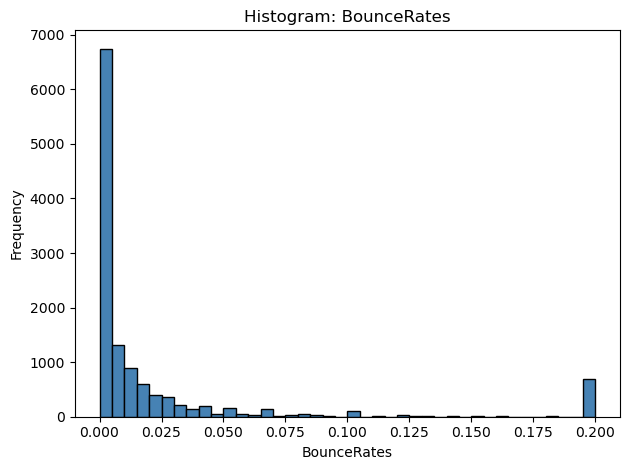

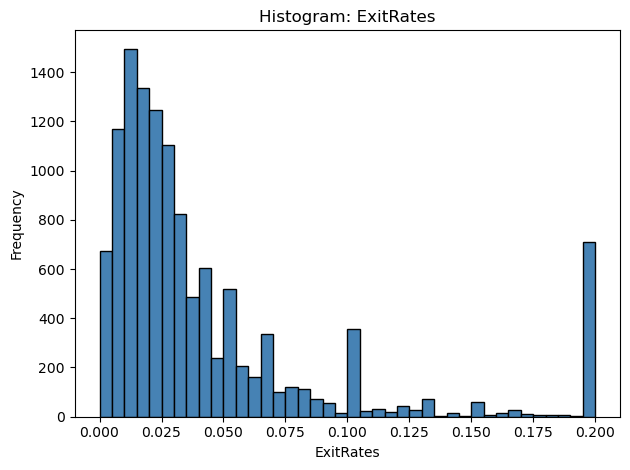

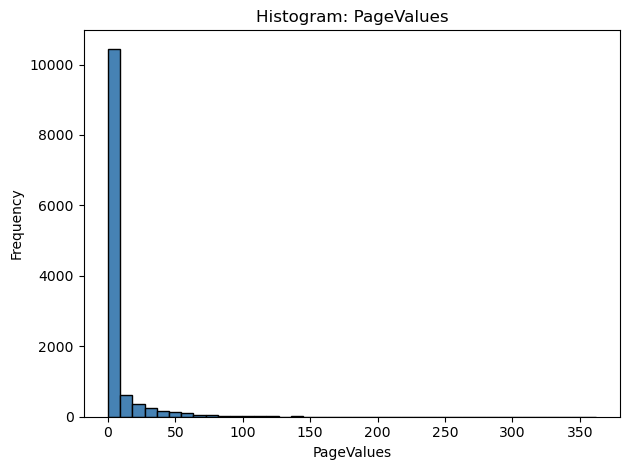

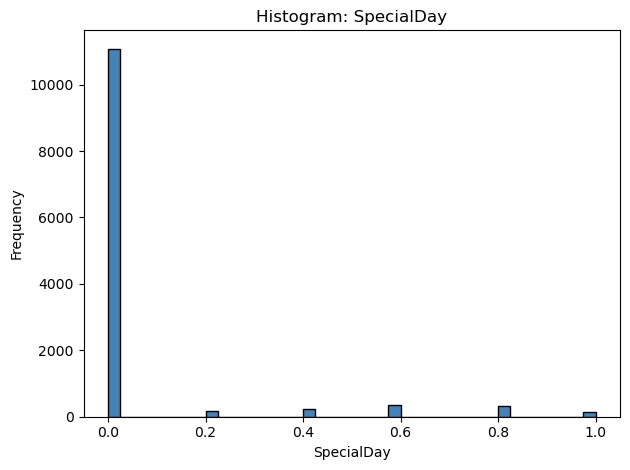

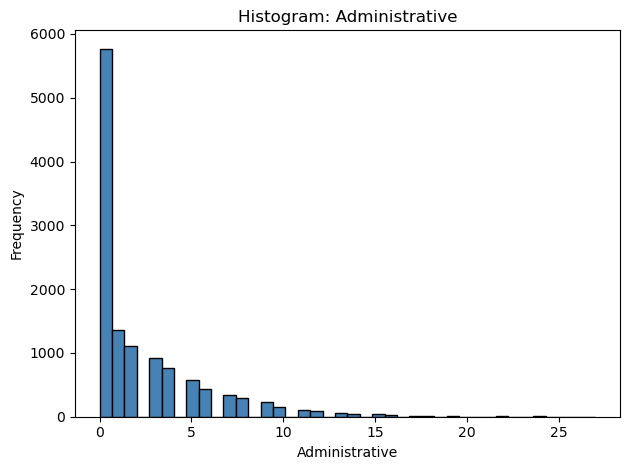

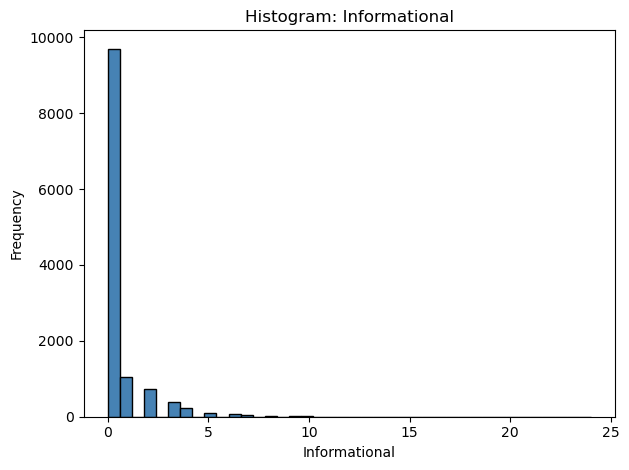

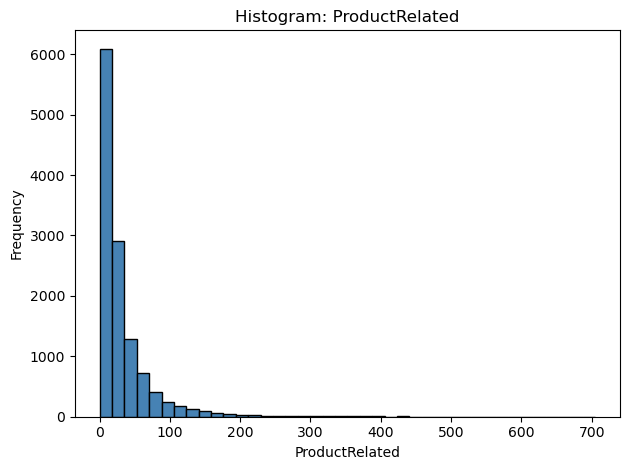

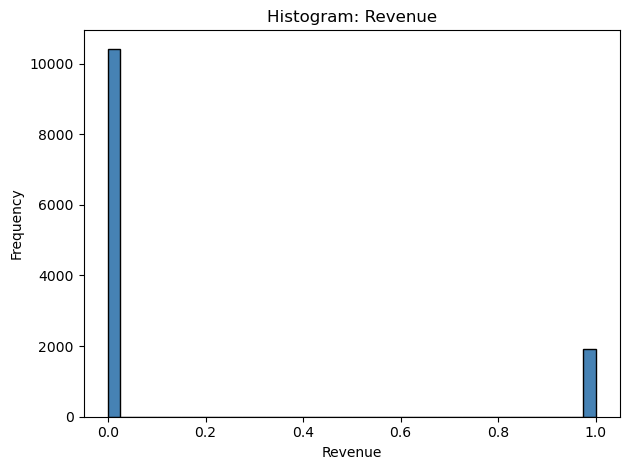

Histograms saved to Online_Shoppers_dataset_Results\Plots
Overall purchase rate: 0.155


In [6]:

# Histograms for key numeric columns

# Generating histograms for selected features to understand their distributions
for col in ["BounceRates", "ExitRates", "PageValues", "SpecialDay",
            "Administrative", "Informational", "ProductRelated", "Revenue"]:
    
    if col in df.columns:
        data = df[col].dropna()
        
        # Converting boolean target to integers for easier plotting
        if data.dtype == bool:
            data = data.astype(int)
        
        plt.figure()
        plt.hist(data, bins=40, color="steelblue", edgecolor="black")
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        
        # Saving each plot into the plots directory
        plt.savefig(os.path.join(PLOTS_DIR, f"hist_{col}.png"))
        plt.show()
        plt.close()

print("Histograms saved to", PLOTS_DIR)

# Checking the overall conversion (purchase) rate
if "Revenue" in df.columns:
    print(f"Overall purchase rate: {df['Revenue'].mean():.3f}")


**3. Applies data preprocessing using scikit-learn pipelines**

a. Handles missing values in numerical and categorical columns.

b. Converts boolean variables to consistent formats.

c. Standardises numeric features using StandardScaler.

d. One-hot encodes categorical variables using OneHotEncoder.

e. Produces a clean, fully numeric feature matrix suitable for clustering.

In [7]:

#  Feature Selection


# Defining the numeric and categorical features I want to work with
numeric_feats = [
    "Administrative", "Administrative_Duration",
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "SpecialDay"
]

categorical_feats = [
    "Month", "OperatingSystems", "Browser", "Region",
    "TrafficType", "VisitorType", "Weekend"
]

# Keeping only the features that actually exist in the dataset
numeric_feats = [c for c in numeric_feats if c in df.columns]
categorical_feats = [c for c in categorical_feats if c in df.columns]

# Final feature list
features = numeric_feats + categorical_feats
X = df[features].copy()

# Handling missing values:
# - Numeric: median imputation
# - Categorical: mode imputation
for c in numeric_feats:
    X[c] = X[c].fillna(X[c].median())

for c in categorical_feats:
    X[c] = X[c].fillna(X[c].mode().iloc[0])


In [8]:

#  Preprocessing

# Setting up column transformations:
# - Scaling numeric features
# - One-hot encoding categorical features
ct = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_feats)
])

# Applying the transformations to the feature matrix
X_prepared = ct.fit_transform(X)

print("Prepared data shape:", X_prepared.shape)


Prepared data shape: (12330, 75)


**4. Determines optimal number of clusters**

a. Computes silhouette scores for k = 2–10.

b. Selects the best k based on the highest silhouette score (k = 5).

c. Saves silhouette score plots for documentation.

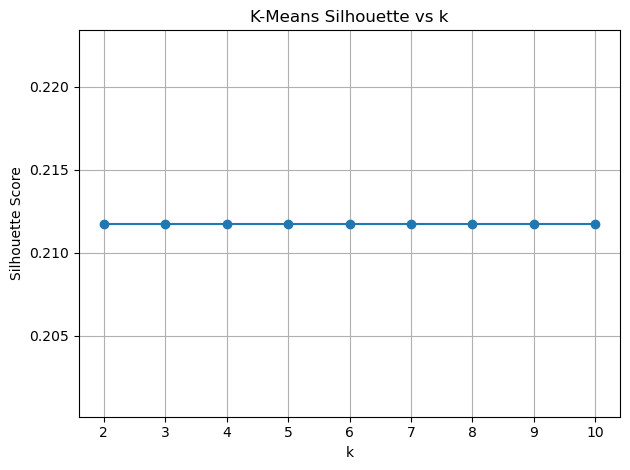

Best k by silhouette: 2


In [9]:

#  Optimal k Selection

# Trying different values of k using the silhouette score as the evaluation metric
k_range = range(2, 11)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=5, n_init=10, random_state=42)  # (Note: using the same structure as my original loop)
    labels = km.fit_predict(X_prepared)
    sil_scores.append(silhouette_score(X_prepared, labels))

# Selecting the best k based on the highest silhouette score
best_k = list(k_range)[int(np.argmax(sil_scores))]

# Plotting silhouette scores across the k range
plt.figure()
plt.plot(list(k_range), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("K-Means Silhouette vs k")
plt.grid(True)
plt.tight_layout()

# Saving the silhouette comparison plot
plt.savefig(os.path.join(PLOTS_DIR, "kmeans_silhouette_vs_k.png"))
plt.show()
plt.close()

print("Best k by silhouette:", best_k)


In [10]:
# Setting k manually 
best_k = 5
print("Using fixed k =", best_k)


Using fixed k = 5


**5. Builds two clustering models**

a. K-Means (baseline, distance-based clustering)

b. Gaussian Mixture Model (GMM) (probabilistic clustering to capture overlapping behaviours)

In [ ]:

#  Clustering (KMeans + GMM)


# Running KMeans clustering using the chosen number of clusters
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(X_prepared)
labels_km = kmeans.labels_

# Running Gaussian Mixture Model (GMM) for a softer, probabilistic clustering approach
gmm = GaussianMixture(n_components=best_k, covariance_type="full", random_state=42).fit(X_prepared)
labels_gmm = gmm.predict(X_prepared)


**6. Evaluates both clustering models using internal metrics**

a. Silhouette Score

b. Calinski–Harabasz Index

c. Davies–Bouldin Index

d. Cluster comparison table saved for reporting

In [ ]:

#  Evaluation

# Function to compute standard clustering evaluation metrics
def evaluate(Xs, labels):
    return {
        "silhouette": silhouette_score(Xs, labels),
        "calinski_harabasz": calinski_harabasz_score(Xs, labels),
        "davies_bouldin": davies_bouldin_score(Xs, labels)
    }

# Evaluating both clustering approaches
metrics_km = evaluate(X_prepared, labels_km)
metrics_gmm = evaluate(X_prepared, labels_gmm)

# Combining the results into a single table for comparison
metrics_df = pd.DataFrame([
    {"Model": f"K-Means (k={best_k})", **metrics_km},
    {"Model": f"GMM (k={best_k})", **metrics_gmm}
])

# Saving the evaluation results
metrics_df.to_csv(os.path.join(TABLES_DIR, "model_metrics.csv"), index=False)

display(metrics_df)
print("Model metrics saved to", TABLES_DIR)


**7. Visualises clusters**

a. Applies PCA (2 components) to reduce dimensionality.

b. Produces and saves scatter plots for both K-Means and GMM cluster structures.

c. Creates bar charts showing average purchase rates per cluster.

In [ ]:

#  PCA Plots

# Reducing the processed feature space to 2 principal components for visualization
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_prepared)

# Helper function to plot cluster assignments in PCA space
def scatter_clusters(X2, labels, title, fname):
    plt.figure(figsize=(7,6))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=8, cmap="viridis")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, fname))
    plt.show()
    plt.close()

# PCA plots for both clustering models
scatter_clusters(X2, labels_km, f"K-Means Clusters (k={best_k})", "pca_kmeans.png")
scatter_clusters(X2, labels_gmm, f"GMM Clusters (k={best_k})", "pca_gmm.png")

print("PCA plots saved to", PLOTS_DIR)


**8. Generates cluster interpretation and profiling**

a. Profiles each cluster based on averaged numerical features.

b. Analyses behavioural patterns such as quick-exit users, engaged non-buyers, high-intent buyers, returning visitors, and seasonal traffic.

In [ ]:

#  Cluster Profiling

# Attaching cluster labels from both models to the original dataframe
profile_df = df.copy()
profile_df["Cluster_KM"] = labels_km
profile_df["Cluster_GMM"] = labels_gmm

# Computing mean values of numeric features for each cluster (K-Means)
km_profile = profile_df.groupby("Cluster_KM")[numeric_feats].mean().round(3)
km_profile.to_csv(os.path.join(TABLES_DIR, "cluster_profile_kmeans.csv"))
display(km_profile)

# Doing the same for GMM clusters
gmm_profile = profile_df.groupby("Cluster_GMM")[numeric_feats].mean().round(3)
gmm_profile.to_csv(os.path.join(TABLES_DIR, "cluster_profile_gmm.csv"))
display(gmm_profile)

# If revenue exists, compute the average purchase rate per cluster
if "Revenue" in df.columns:
    km_rev = profile_df.groupby("Cluster_KM")["Revenue"].mean().round(3)
    gmm_rev = profile_df.groupby("Cluster_GMM")["Revenue"].mean().round(3)

    km_rev.to_csv(os.path.join(TABLES_DIR, "purchase_rate_kmeans.csv"))
    display(km_rev.to_frame("Avg_Revenue").style.set_caption("K-Means: Average Revenue per Cluster"))

    gmm_rev.to_csv(os.path.join(TABLES_DIR, "purchase_rate_gmm.csv"))
    display(gmm_rev.to_frame("Avg_Revenue").style.set_caption("GMM: Average Revenue per Cluster"))

    # Bar plot for purchase rate across K-Means clusters
    plt.figure()
    km_rev.plot(kind="bar", color="orange")
    plt.title("Purchase Rate by Cluster (K-Means)")
    plt.xlabel("Cluster")
    plt.ylabel("Purchase Rate")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "purchase_rate_kmeans.png"))
    plt.show()
    plt.close()

print("\n✅ All exploration, tables, and visualizations saved under:", os.path.abspath(PREVIEW_DIR))



**Tasks Modeled**

a. Unsupervised segmentation of online shoppers.

b. Clustering of behavioural and contextual features.

c. Comparison of K-Means and GMM performance.

d. Identification of natural shopper groups without labels.
    
**CONCLUSION**

This Python workflow demonstrates how to build a complete, reproducible clustering pipeline for real-world behavioural analytics.
It integrates EDA, preprocessing, clustering, evaluation, and interpretation into a structured process.

The final output provides actionable insights into:

a.How different shoppers interact with an e-commerce website.

b.Which groups show high or low purchase intent.

c.How businesses can personalise marketing and improve user experience based on these patterns.

